# Basic Model Steps
- Take clustered data
- Chunk satellite image
- For each image, associate random socioeconomic data
- Treat as direct label

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

In [12]:
# Have to add some conversion logic because plaintext geometry is not understood in CSV
path = '../outputs/clustered-data.csv'
df = pd.read_csv(path)
gdf = gpd.GeoDataFrame(
    df.loc[:, [c for c in df.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(df["geometry"]),
    crs="epsg:3857",
)
gdf.sort_values(by='service_index', ascending=False)
gdf

,ward_id,municipality,district,service_index,geometry
0,79800001,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.169350,"POLYGON ((27.851 -26.480, 27.851 -26.482, 27.8..."
1,79800002,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.658822,"POLYGON ((27.881 -26.493, 27.881 -26.493, 27.8..."
2,79800003,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.245713,"POLYGON ((27.870 -26.468, 27.871 -26.471, 27.8..."
3,79800004,City of Johannesburg Metropolitan Municipality,City of Johannesburg,8.594442,"POLYGON ((27.870 -26.449, 27.870 -26.449, 27.8..."
4,79800005,City of Johannesburg Metropolitan Municipality,City of Johannesburg,8.745830,"POLYGON ((27.810 -26.424, 27.814 -26.425, 27.8..."
...,...,...,...,...,...
130,79800131,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.049961,"POLYGON ((27.873 -26.490, 27.873 -26.490, 27.8..."
131,79800132,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.765982,"POLYGON ((28.088 -25.984, 28.092 -25.988, 28.0..."
132,79800133,City of Johannesburg Metropolitan Municipality,City of Johannesburg,7.922886,"POLYGON ((28.196 -25.985, 28.196 -25.985, 28.1..."
133,79800134,City of Johannesburg Metropolitan Municipality,City of Johannesburg,9.440186,"POLYGON ((27.967 -26.017, 27.967 -26.017, 27.9..."


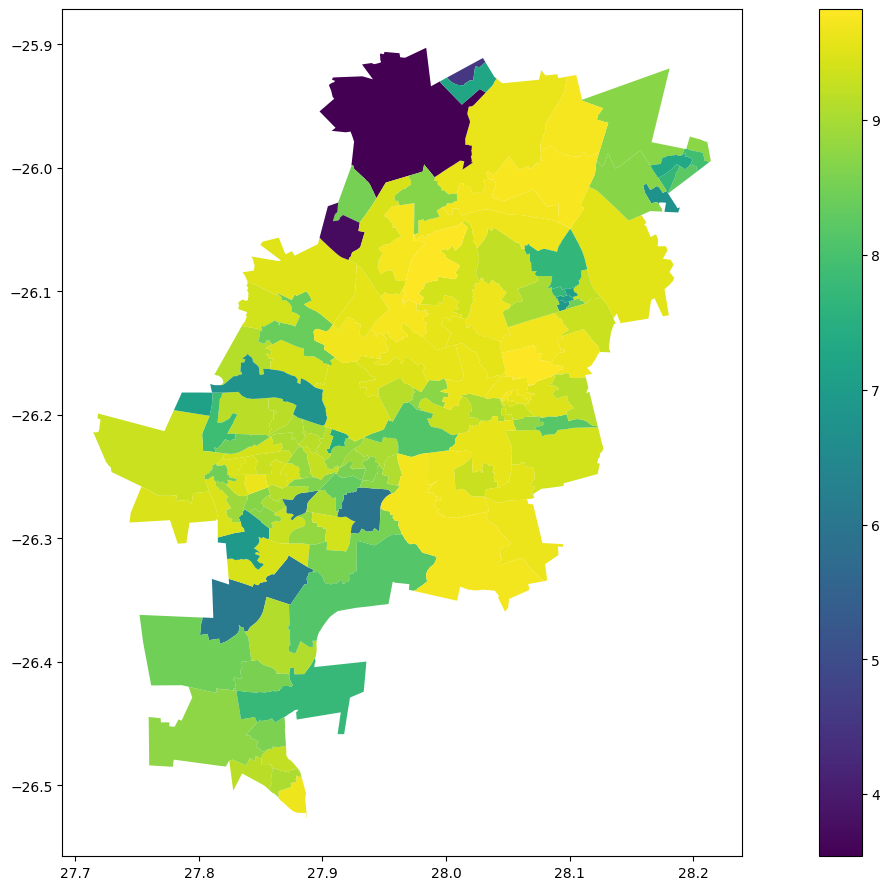

In [13]:
figsize = (20, 11)

gdf.plot('service_index', legend=True, figsize=figsize);

In [17]:
from rasterio.mask import mask
# the polygon GeoJSON geometry
geoms = [gdf['geometry'][0]]
image_file = '../data/images/20230318_075512_29_249d_3B_AnalyticMS_SR_8b.tif'

print(geoms)
# load the raster, mask it by the polygon and crop it
# Getting error where raster does not overlap polygon. Need to figure out how to make sure geotiff data has coordinates because it doesn't look like it does (or alternatively CRS above is wrong)
with rasterio.open(image_file) as tile:
    out_image, out_transform = mask(tile, geoms, crop=True)
out_meta = tile.meta.copy()

POLYGON ((625935 7093875, 625935 7120602, 588822 7120602, 588822 7093875, 625935 7093875))


In [ ]:
# save the resulting raster
out_meta.update({"driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform})

with rasterio.open("../outputs/masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)